In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
datasets = [
    'enwik8',
    'Hutter Prize',
    'One Billion Word',
    'Penn Treebank (Word Level)',
    'Penn Treebank (Character Level)',
    'Text8',
    'WikiText-2',
    'WikiText-103'
]

## Finding the average worth length of datasets

In [3]:
# You may have to follow this tutorial to download the punkt package
# https://stackoverflow.com/a/50406704
from nltk.tokenize import word_tokenize
def average_word_length(filename):
    f = open(filename, 'r')
    text = f.read()
    tokens = word_tokenize(text)
    return sum([len(word) for word in tokens])/len(tokens)
    f.close()

In [4]:
enwik8_word_length = average_word_length('Datasets/enwik8')
enwik8_word_length

3.69870499708762

In [5]:
# Figure from Alex Graves
# See https://arxiv.org/pdf/1308.0850.pdf
Penn_Treebank_word_length = 5.6

In [6]:
text8_word_length = average_word_length('Datasets/text8')
text8_word_length

4.879836942071761

In [7]:
WikiText_2_word_length = average_word_length('Datasets/wikitext-2-v1/wikitext-2/wiki.test.tokens')
WikiText_2_word_length

3.625893480561174

In [8]:
WikiText_103_word_length = average_word_length('Datasets/wikitext-103-v1/wikitext-103/wiki.test.tokens')
WikiText_103_word_length

4.087534417526692

## Utilities

In [9]:
from datetime import datetime
def date_to_num(date_str):
    date_str_extra = date_str + ' 00:00:00.000000+00:00'
    return int(datetime.fromisoformat(date_str_extra).timestamp()/(24 * 60 * 60))

def num_to_date(date_number):
    return datetime.fromtimestamp(date_number * 24 * 60 * 60)

def add_datenum_to_df(df):
    df['Date Number'] = df['Date'].apply(date_to_num)

def add_entropy(df, average_word_length, perplexity_field):
    def entropy_from_perplexity(p):
        return (np.log(p)/np.log(2))/average_word_length
    df['Bit per Character (BPC)'] = df[perplexity_field].apply(entropy_from_perplexity)

In [10]:
def SOTA_models(df):
    SOTA_df = pd.DataFrame()
    df = df.sort_values('Date Number')
    best_entropy = df.iloc[0]['Bit per Character (BPC)'] + 1.0
    for index, row in df.iterrows():
        if row['Bit per Character (BPC)'] < best_entropy:
            SOTA_df = SOTA_df.append(row)
            best_entropy = row['Bit per Character (BPC)']
    return SOTA_df

import time
def SOTA_models_inserted(df, current_day, day_interval):
    SOTA_df = SOTA_models(df)
    days = list(sorted(SOTA_df['Date Number']))
    days.append(current_day)
    SOTA_models_inserted = pd.DataFrame()
    i = 0
    for _, row in SOTA_df.sort_values('Date Number').iterrows():
        previous_day = int(days[i])
        next_day = int(days[i + 1])
        i += 1
        for d in range(previous_day, next_day, day_interval):
            new_row = row.copy()
            new_row['Date Number'] = d
            new_row['Date'] = num_to_date(d)
            SOTA_models_inserted = SOTA_models_inserted.append(new_row)
    return SOTA_models_inserted

In [11]:
# Regression tools
from sklearn.linear_model import LinearRegression
def solve_intersection_linear(df, entropy_estimate):
    X = df['Date Number'].to_numpy().reshape(-1, 1)
    y = df['Bit per Character (BPC)'].to_numpy().reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    eq = [reg.coef_[0][0], reg.intercept_[0]]
    intersection_date = (entropy_estimate - eq[1]) / eq[0]
    return (eq, intersection_date)

In [12]:
# Plotting tools

# Date time conversion registration
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

def plot_models(df, name):
    sns.set_style("ticks")
    fig, ax = plt.subplots(figsize=(12, 8))
    x_dates = df['Date Number'].apply(num_to_date)
    sns.set(font_scale=1.2)
    ax.plot(x_dates,
            df['Bit per Character (BPC)'],
            '-o',
            color='purple')
    ax.set(xlabel="Date", ylabel="Bits per character (BPC)",
           title="Entropy of SOTA language models on " + name + " dataset over time")

    # Format the x axis
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=52))
    ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

    plt.show()

In [13]:
current_date = '2021-10-02' # Can be changed. This is just for reproducibility
current_date_number = date_to_num(current_date)
current_date_number

18902

In [14]:
def print_predicted_date(df, entropy_level):
    eq_data = solve_intersection_linear(df, entropy_level)
    print("Predicted date until entropy=" + str(np.round(entropy_level, 1)) + ":", 
          str(num_to_date(eq_data[1])).split(' ')[0])

def plot_and_show_intersection(SOTA_df, name, entropy_range=np.arange(0.4, 0.9, 0.1)):
    plot_models(SOTA_df, name)
    for entropy_level in entropy_range:
        print_predicted_date(SOTA_df, entropy_level)
    SOTA_inserted = SOTA_models_inserted(SOTA_df, current_date_number, 14)
    plot_models(SOTA_inserted, name)
    for entropy_level in entropy_range:
        print_predicted_date(SOTA_inserted, entropy_level)

## enwik8

In [15]:
enwik8_models = pd.read_csv('Models/enwik8 - models.csv')
add_datenum_to_df(enwik8_models)
enwik8_models_SOTA = SOTA_models(enwik8_models)
enwik8_models_SOTA.head(5)

,Model,Bit per Character (BPC),Number of params,Extra Training Data,Paper Title,Date,Date Number
36,LSTM (7 layers),1.670,NaN,0.0,[object Object],2013-08-04,15921.0
31,Recurrent Highway Networks,1.270,46M,0.0,[object Object],2016-07-12,16994.0
29,Large mLSTM,1.240,46M,0.0,[object Object],2016-09-26,17070.0
28,AWD-LSTM (3 layers),1.232,47M,0.0,[object Object],2018-03-22,17612.0
20,Transformer (64 layers),1.060,235M,0.0,[object Object],2018-08-09,17752.0


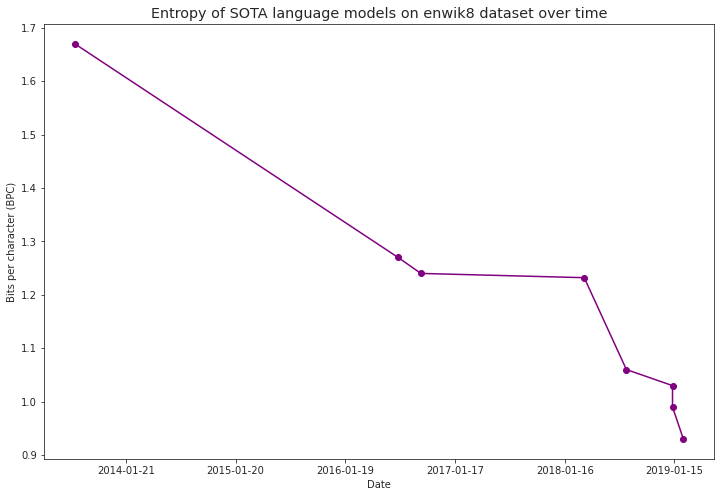

Predicted date until entropy=0.4: 2024-02-18
Predicted date until entropy=0.5: 2023-04-17
Predicted date until entropy=0.6: 2022-06-15
Predicted date until entropy=0.7: 2021-08-12
Predicted date until entropy=0.8: 2020-10-10


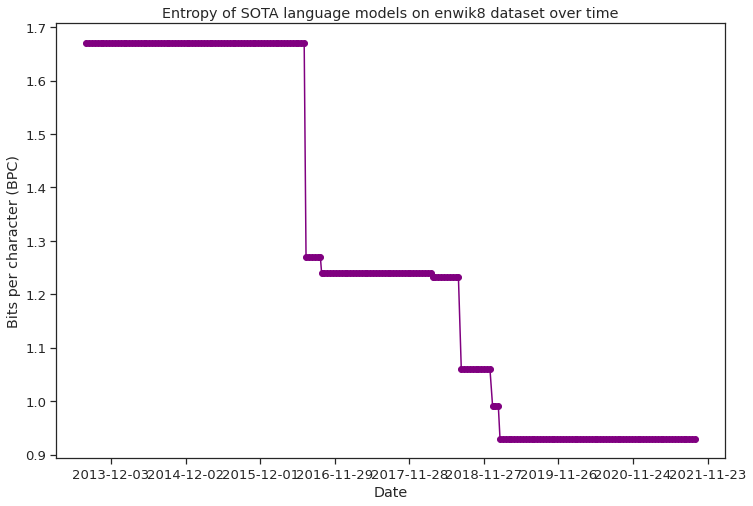

Predicted date until entropy=0.4: 2024-09-11
Predicted date until entropy=0.5: 2023-11-24
Predicted date until entropy=0.6: 2023-02-06
Predicted date until entropy=0.7: 2022-04-21
Predicted date until entropy=0.8: 2021-07-03


In [16]:
plot_and_show_intersection(enwik8_models_SOTA, "enwik8")

## Hutter Prize

In [17]:
Hutter_Prize_models = pd.read_csv('Models/Hutter Prize - models.csv').dropna()
add_datenum_to_df(Hutter_Prize_models)
Hutter_Prize_models_SOTA = SOTA_models(Hutter_Prize_models)
Hutter_Prize_models_SOTA.head(5)

,Model,Bit per Character (BPC),Number of params,Extra Training Data,Paper Title,Date,Date Number
15,Large RHN,1.27,46M,0.0,[object Object],2016-07-12,16994.0
13,Large mLSTM +emb +WN +VD,1.24,46M,0.0,[object Object],2016-09-26,17070.0
9,mLSTM + dynamic eval,1.08,46M,0.0,[object Object],2017-09-21,17430.0
7,64-layer Character Transformer Model,1.06,235M,0.0,[object Object],2018-08-09,17752.0
3,24-layer Transformer-XL,0.99,277M,0.0,[object Object],2019-01-09,17905.0


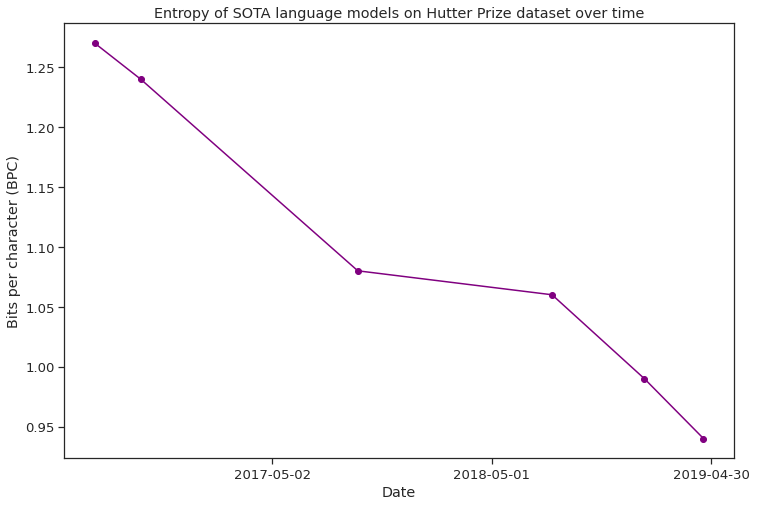

Predicted date until entropy=0.4: 2024-04-12
Predicted date until entropy=0.5: 2023-05-18
Predicted date until entropy=0.6: 2022-06-22
Predicted date until entropy=0.7: 2021-07-26
Predicted date until entropy=0.8: 2020-08-30


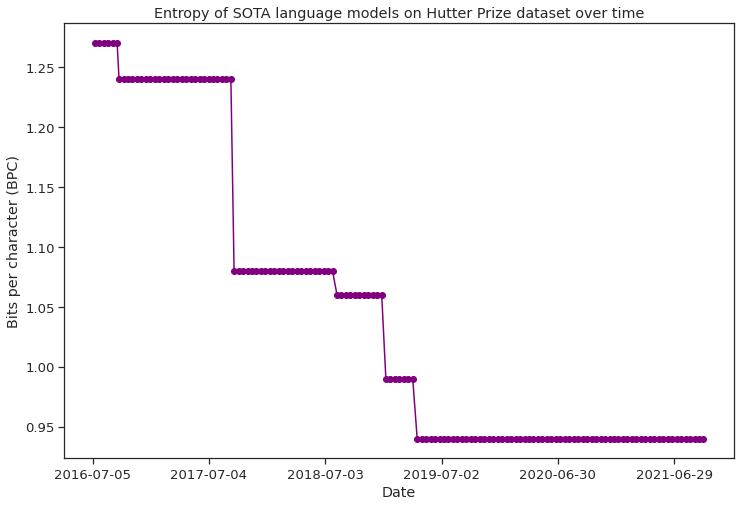

Predicted date until entropy=0.4: 2027-12-08
Predicted date until entropy=0.5: 2026-07-28
Predicted date until entropy=0.6: 2025-03-17
Predicted date until entropy=0.7: 2023-11-05
Predicted date until entropy=0.8: 2022-06-25


In [18]:
plot_and_show_intersection(Hutter_Prize_models_SOTA, "Hutter Prize")

## One Billion Word

In [19]:
One_Billion_Word_models = pd.read_csv('Models/One Billion Word - models.csv')
add_datenum_to_df(One_Billion_Word_models)
# I estimate 5.0 as the average word length because the dataset cannot load on my computer
average_word_length = 5.0
add_entropy(One_Billion_Word_models, average_word_length, 'PPL') 
One_Billion_Word_models_SOTA = SOTA_models(One_Billion_Word_models)
One_Billion_Word_models_SOTA.head(5)

,Model,PPL,Number of params,Validation perplexity,Extra Training Data,Paper Title,Date,Date Number,Bit per Character (BPC)
20,RNN-1024 + 9 Gram,51.30,20B,Unk,0.0,[object Object],2013-12-11,16050.0,1.136177
15,LSTM-8192-1024,30.60,1.8B,Unk,0.0,[object Object],2016-02-07,16838.0,0.987092
14,LSTM-8192-1024 + CNN Input,30.00,1.04B,Unk,0.0,[object Object],2016-02-07,16838.0,0.981378
7,10 LSTM+CNN inputs + SNM10-SKIP (ensemble),23.70,43B,Unk,0.0,[object Object],2016-02-07,16838.0,0.913363
4,Adaptive Input Very Large,23.02,1.0B,22.92,0.0,[object Object],2018-09-28,17802.0,0.904963


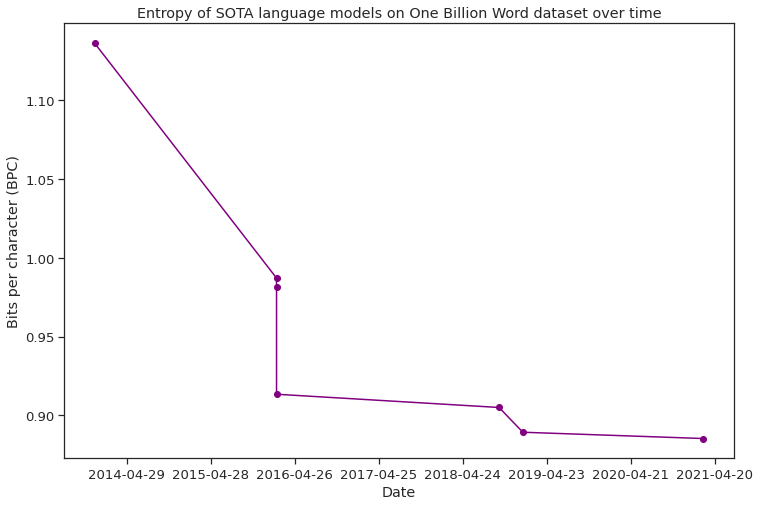

Predicted date until entropy=0.4: 2035-07-31
Predicted date until entropy=0.5: 2032-04-19
Predicted date until entropy=0.6: 2029-01-06
Predicted date until entropy=0.7: 2025-09-26
Predicted date until entropy=0.8: 2022-06-15


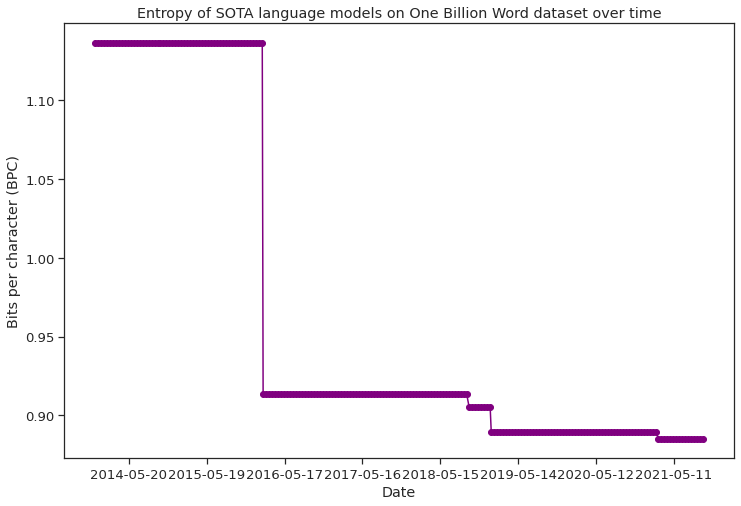

Predicted date until entropy=0.4: 2032-06-23
Predicted date until entropy=0.5: 2029-11-21
Predicted date until entropy=0.6: 2027-04-22
Predicted date until entropy=0.7: 2024-09-19
Predicted date until entropy=0.8: 2022-02-18


In [20]:
plot_and_show_intersection(One_Billion_Word_models_SOTA, "One Billion Word")

## Penn Treebank (Word Level)

In [21]:
Penn_Treebank_Word_Level_models = pd.read_csv('Models/Penn Treebank (Word Level) - models.csv')
add_datenum_to_df(Penn_Treebank_Word_Level_models)
add_entropy(Penn_Treebank_Word_Level_models, Penn_Treebank_word_length, 'Test perplexity')
Penn_Treebank_Word_Level_models_SOTA = SOTA_models(Penn_Treebank_Word_Level_models)
Penn_Treebank_Word_Level_models_SOTA.head(5)

,Model,Test perplexity,Validation perplexity,Number of parameters,Extra training data,Paper Title,Date,Date Number,Bit per Character (BPC)
34,Zaremba et al. (2014) - LSTM (large),78.4,82.2,Unk,0.0,[object Object],2014-09-08,16321.0,1.123711
33,Gal & Ghahramani (2016) - Variational LSTM (la...,75.2,77.9,Unk,0.0,[object Object],2015-12-16,16785.0,1.112975
31,Recurrent highway networks,65.4,67.9,23M,0.0,[object Object],2016-07-12,16994.0,1.077003
30,NAS Cell,64.0,Unk,25M,0.0,[object Object],2016-11-05,17110.0,1.071429
28,AWD-LSTM,57.3,60,24M,0.0,[object Object],2017-08-07,17385.0,1.042940


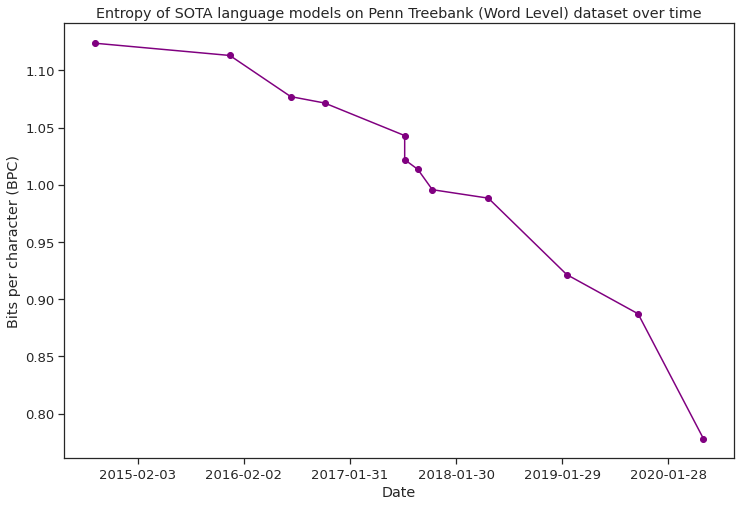

Predicted date until entropy=0.4: 2027-11-22
Predicted date until entropy=0.5: 2026-03-15
Predicted date until entropy=0.6: 2024-07-06
Predicted date until entropy=0.7: 2022-10-28
Predicted date until entropy=0.8: 2021-02-18


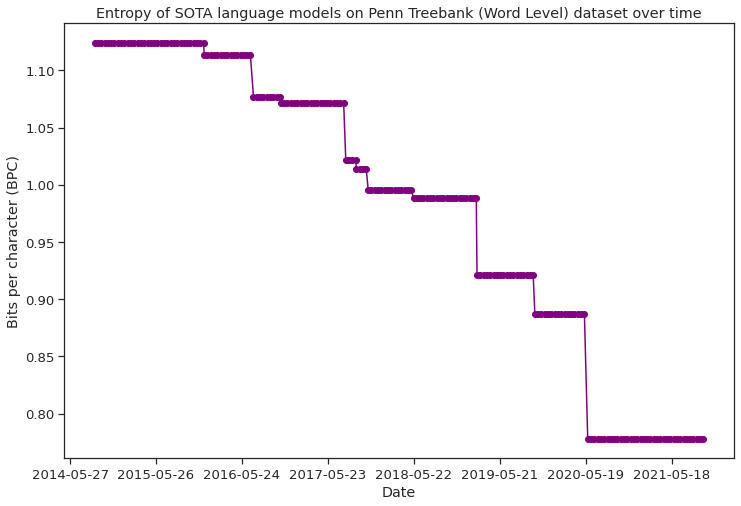

Predicted date until entropy=0.4: 2028-02-08
Predicted date until entropy=0.5: 2026-05-28
Predicted date until entropy=0.6: 2024-09-14
Predicted date until entropy=0.7: 2023-01-02
Predicted date until entropy=0.8: 2021-04-21


In [22]:
plot_and_show_intersection(Penn_Treebank_Word_Level_models_SOTA, "Penn Treebank (Word Level)")

## Penn Treebank (Character Level)

In [23]:
Penn_Treebank_Character_Level_models = pd.read_csv('Models/Penn Treebank (Character Level) - models.csv')
add_datenum_to_df(Penn_Treebank_Character_Level_models)
Penn_Treebank_Character_Level_models_SOTA = SOTA_models(Penn_Treebank_Character_Level_models)
Penn_Treebank_Character_Level_models_SOTA.head(5)

,Model,Bit per Character (BPC),Number of params,Extra Training Data,Paper Title,Date,Date Number
13,2-layer Norm HyperLSTM,1.219,14.4M,0.0,[object Object],2016-09-27,17071.0
12,NASCell,1.214,16.3M,0.0,[object Object],2016-11-05,17110.0
11,FS-LSTM-2,1.193,27M,0.0,[object Object],2017-05-24,17310.0
9,FS-LSTM-4,1.190,27M,0.0,[object Object],2017-05-24,17310.0
8,6-layer QRNN,1.187,13.8M,0.0,[object Object],2018-03-22,17612.0


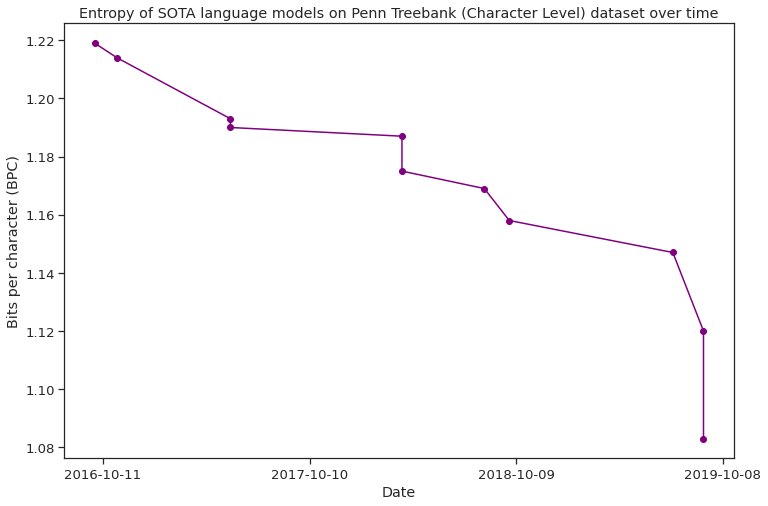

Predicted date until entropy=0.4: 2040-09-12
Predicted date until entropy=0.5: 2037-10-12
Predicted date until entropy=0.6: 2034-11-12
Predicted date until entropy=0.7: 2031-12-12
Predicted date until entropy=0.8: 2029-01-11


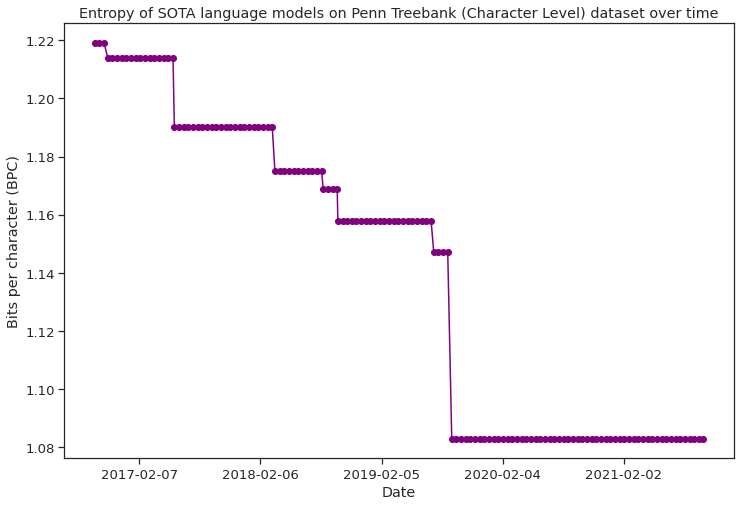

Predicted date until entropy=0.4: 2041-03-24
Predicted date until entropy=0.5: 2038-04-05
Predicted date until entropy=0.6: 2035-04-17
Predicted date until entropy=0.7: 2032-04-28
Predicted date until entropy=0.8: 2029-05-10


In [24]:
plot_and_show_intersection(Penn_Treebank_Character_Level_models_SOTA, "Penn Treebank (Character Level)")

## Text8

In [25]:
Text8_models = pd.read_csv('Models/Text8 - models.csv')
add_datenum_to_df(Text8_models)
Text8_models_SOTA = SOTA_models(Text8_models)
Text8_models_SOTA.head(5)

,Model,Bit per Character (BPC),Number of params,Extra Training Data,Paper Title,Date,Date Number
21,"td-LSTM (Zhang et al., 2016)",1.63,NaN,0.0,[object Object],2016-02-26,16857.0
20,td-LSTM-large,1.49,NaN,0.0,[object Object],2016-02-26,16857.0
18,BN LSTM,1.36,16M,0.0,[object Object],2016-03-30,16890.0
15,Large RHN,1.27,46M,0.0,[object Object],2016-07-12,16994.0
13,mLSTM + dynamic eval,1.19,45M,0.0,[object Object],2017-09-21,17430.0


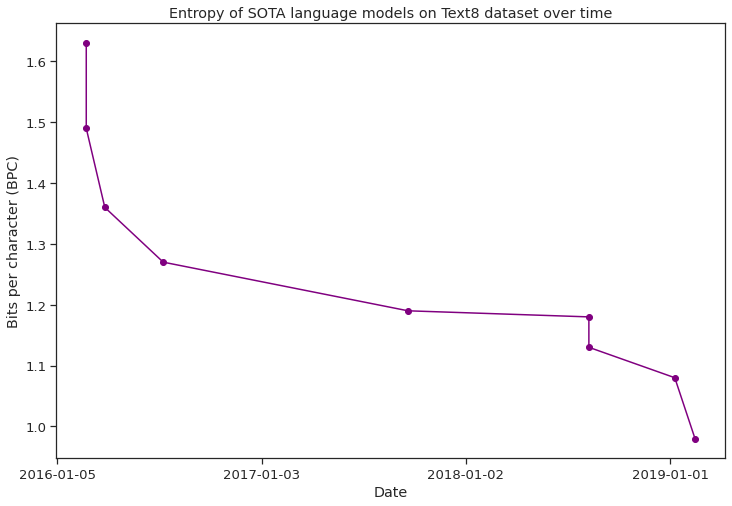

Predicted date until entropy=0.4: 2023-08-15
Predicted date until entropy=0.5: 2022-11-30
Predicted date until entropy=0.6: 2022-03-17
Predicted date until entropy=0.7: 2021-07-03
Predicted date until entropy=0.8: 2020-10-18


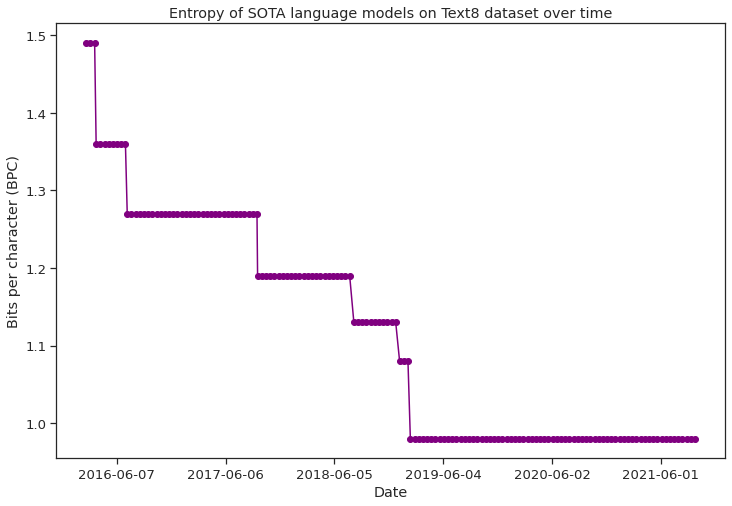

Predicted date until entropy=0.4: 2027-08-27
Predicted date until entropy=0.5: 2026-06-09
Predicted date until entropy=0.6: 2025-03-21
Predicted date until entropy=0.7: 2024-01-02
Predicted date until entropy=0.8: 2022-10-14


In [26]:
plot_and_show_intersection(Text8_models_SOTA, "Text8")

## WikiText-2

In [27]:
WikiText_2_models = pd.read_csv('Models/WikiText-2 - models.csv')
add_datenum_to_df(WikiText_2_models)
add_entropy(WikiText_2_models, WikiText_2_word_length, 'Test perplexity')
WikiText_2_models_SOTA = SOTA_models(WikiText_2_models)
WikiText_2_models_SOTA.head(5)

,Model,Test perplexity,Validation perplexity,Number of parameters,Extra Training Data,Paper Title,Date,Date Number,Bit per Character (BPC)
24,Inan et al. (2016) - Variational LSTM (tied) (...,87.0,91.5,NaN,0.0,[object Object],2016-11-04,17109.0,1.776926
23,Grave et al. (2016) - LSTM + continuous cache ...,68.9,NaN,NaN,0.0,[object Object],2016-12-13,17148.0,1.684118
22,Melis et al. (2017) - 1-layer LSTM (tied),65.9,69.3,24M,0.0,[object Object],2017-07-18,17365.0,1.666405
21,AWD-LSTM,65.8,68.6,33M,0.0,[object Object],2017-08-07,17385.0,1.665801
10,AWD-LSTM + continuous cache pointer,52.0,53.8,33M,0.0,[object Object],2017-08-07,17385.0,1.572148


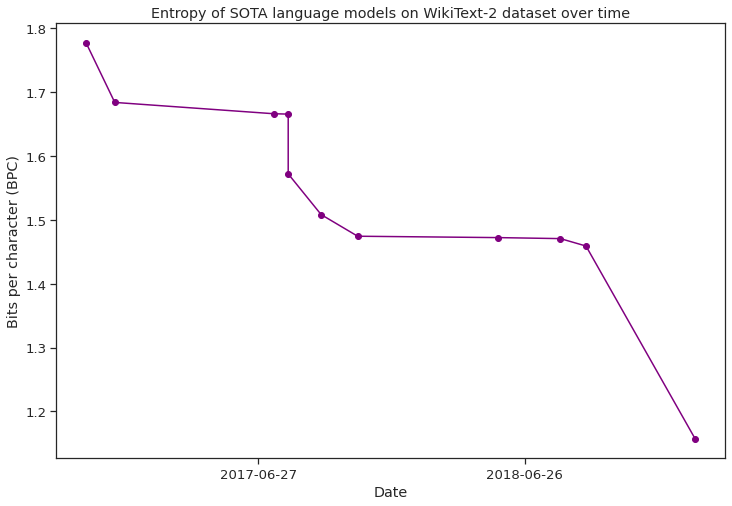

Predicted date until entropy=0.4: 2023-05-30
Predicted date until entropy=0.5: 2022-12-04
Predicted date until entropy=0.6: 2022-06-10
Predicted date until entropy=0.7: 2021-12-15
Predicted date until entropy=0.8: 2021-06-22


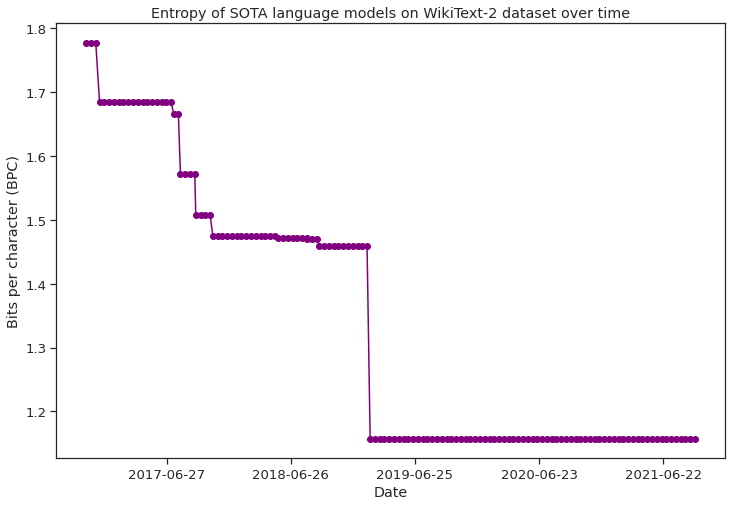

Predicted date until entropy=0.4: 2026-04-05
Predicted date until entropy=0.5: 2025-07-09
Predicted date until entropy=0.6: 2024-10-11
Predicted date until entropy=0.7: 2024-01-15
Predicted date until entropy=0.8: 2023-04-19


In [28]:
plot_and_show_intersection(WikiText_2_models_SOTA, "WikiText-2")

## WikiText-103

In [29]:
WikiText_103_models = pd.read_csv('Models/WikiText-103 - models.csv')
add_datenum_to_df(WikiText_103_models)
add_entropy(WikiText_103_models, WikiText_103_word_length, 'Test perplexity')
WikiText_103_models_SOTA = SOTA_models(WikiText_103_models)
WikiText_103_models_SOTA.head(5)

,Model,Test perplexity,Validation perplexity,Number of parameters,Extra training data,Paper Title,Date,Date Number,Bit per Character (BPC)
55,LSTM,48.7,NaN,NaN,0.0,[object Object],2016-12-13,17148.0,1.371450
50,"Neural cache model (size = 2,000)",40.8,NaN,NaN,0.0,[object Object],2016-12-13,17148.0,1.308979
48,GCNN-14,37.2,-,NaN,0.0,[object Object],2016-12-23,17158.0,1.276376
45,4 layer QRNN,33.0,32,151M,0.0,[object Object],2018-03-22,17612.0,1.234092
40,"LSTM (Hebbian, Cache)",29.7,29.9,NaN,0.0,[object Object],2018-03-27,17617.0,1.196905


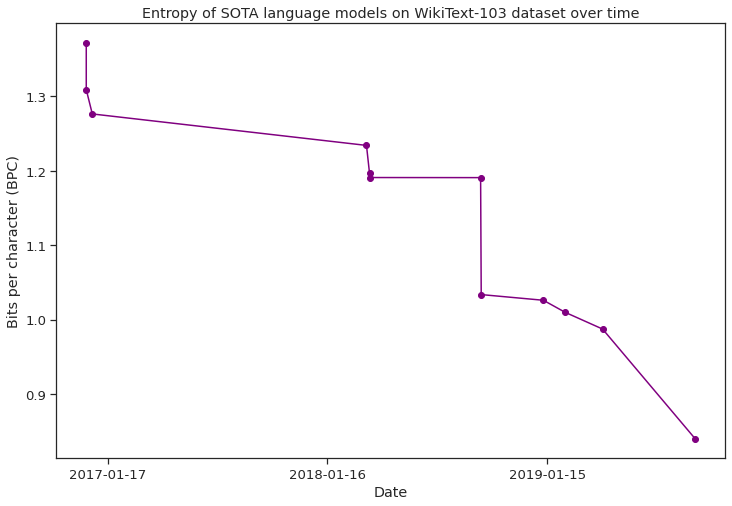

Predicted date until entropy=0.4: 2023-03-02
Predicted date until entropy=0.5: 2022-07-07
Predicted date until entropy=0.6: 2021-11-11
Predicted date until entropy=0.7: 2021-03-18
Predicted date until entropy=0.8: 2020-07-23


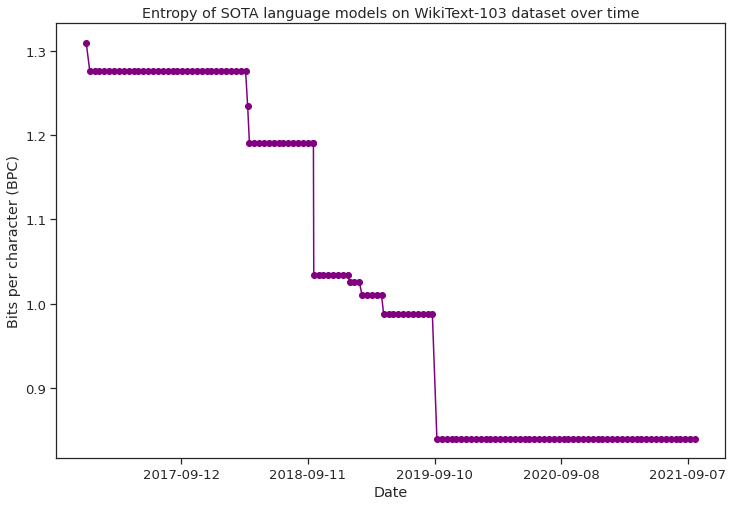

Predicted date until entropy=0.4: 2024-04-27
Predicted date until entropy=0.5: 2023-07-13
Predicted date until entropy=0.6: 2022-09-27
Predicted date until entropy=0.7: 2021-12-11
Predicted date until entropy=0.8: 2021-02-25


In [30]:
plot_and_show_intersection(WikiText_103_models_SOTA, "WikiText-103")